In [78]:
import matplotlib.pyplot as plt
from Objects.Simulation import Simulation
import numpy as np

In [79]:
sim = Simulation(20, 100)
p = sim.run_cav_simluation(5)
records = p.records

Start running CAV simulation: 5-vehicle-platoon with 100ms gap in 20 seconds.
CAV simulation finished.


In [80]:
X_timeline = records[0].keys()
car0_avl = np.array(list(zip(*records[0].values())))

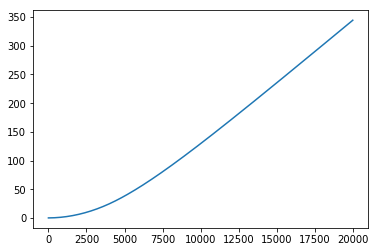

In [81]:
plt.plot(X_timeline, car0[2])
plt.show()

In [82]:
def plot_one_record(record_zipped, dimension, x_timeline):
    for key in record_zipped.keys():
        plt.plot(x_timeline, record_zipped[key][dimension], label = key)
    plt.show()

In [86]:
def plot_records(records):
    x_timeline = records[0].keys()
    record_zipped = {}
    for key in records.keys():
        record_zipped[key] = np.array(list(zip(*records[key].values())))
    for dim in range(3):
        plot_one_record(record_zipped, dim, x_timeline)

Start running CAV simulation: 10-vehicle-platoon with 100ms gap in 25 seconds.
CAV simulation finished.


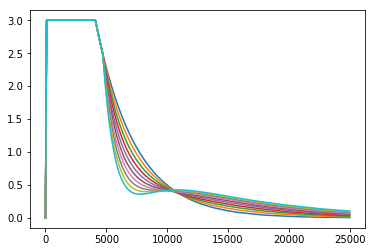

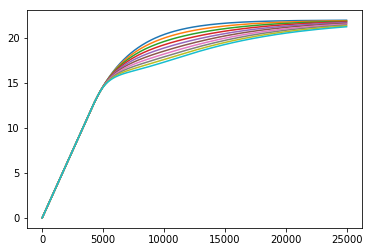

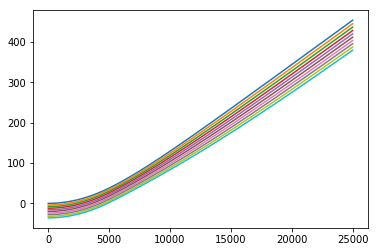

In [93]:
sim = Simulation(25, 100)
p = sim.run_cav_simluation(10)
records = p.records
plot_records(records)